# GPU implementation of Bfastmonitor using Python

The bfast package provides a highly-efficient parallel implementation for the Breaks For Additive Season and Trend (BFASTmonitor) proposed by Verbesselt et al. The implementation is based on OpenCL.

The script below runs bfastmonitor over the timeseries data downloaded in SEPAL in blocks, and patches together tiles to export mean magnitudes and breaks as geotiffs, pngs, and .npy files. The output is also displayed in a digital map. Make sure to run through the cells sequentially.

* First download data using the SEPAL time series downloader (not in this script). The downloads will be saved in your downloads folder and look like: /home/'username'/downloads/Time_series_2020-09-01_16-22-26/0|1|2|3

* Import packages

* Select data

* Set parameters

* Select monitoring period

* Run bfastmonitor

* Load output

* Merge and save output

* Display output




### Import packages

In [2]:
import os # add a comment to test git 
from os.path import expanduser

import wget
import numpy as np
from datetime import datetime
import copy
import matplotlib
import matplotlib.pyplot as plt

import json
import subprocess

from bfast import BFASTMonitor
from bfast.utils import crop_data_dates

import csv
from shutil import copyfile
import pandas as pd
from osgeo import gdal, gdal_array, osr

import time
from tqdm import tqdm

import ipywidgets as widgets
from ipywidgets import Layout
from ipyfilechooser import FileChooser
import folium

# from folium.plugins import FloatImage
# import base64
# import json

from PIL import Image
from matplotlib import cm

# import functions from functions.py and plotting_funcs.py
from functions import set_base_output_dir, set_output_dir, get_data_dict, merge_tiles, set_paths, _find_index_date, normalize, select_negatives, get_julian_dates
from plotting_funcs import save_plot, merge_plots, classify_output, plot_output_matplotlib, set_corners, export_GTiff, classify_magnitudes, merge_plots2

# Import the Timeseries class from time_series.py
from time_series import Timeseries
print(Timeseries.__doc__)

# Import widgets for GUI parameter selection
from widgets import get_widgets, get_dates_widgets
output_directory_chooser, k_chooser,freq_chooser,trend_chooser,hfrac_chooser,level_chooser,backend_chooser, load_chooser, block_size_chooser, plot_display_data_chooser = get_widgets()


    The timeseries class is a wrapper for using SEPAL timeseries data with bfast. 
    It wraps together a data tile with associated dates file and metadata. 
    It also allows for saving and loading the output rasters in a specified directory. 
    


In [3]:
%matplotlib inline

### Select data

#### Select a name for your output folder. All the segments you run through will be saved here: "./stored_time_series/[yourfoldername]



In [4]:
display(output_directory_chooser)

interactive(children=(Text(value='', description='Output storage name: (country/location name, e.g. "Guyana")'…

In [7]:
base_output_dir = set_base_output_dir(output_directory_chooser)

Output directory name: stored_time_series/test


#### Select a time series segment folder using ipyfilechooser.  The standard download location is in downloads/time_series_name/[0,1,2..n]


In [6]:
path = expanduser("~")
file_chooser = FileChooser(path)
display(file_chooser)

FileChooser(path='/home/dven', filename='', title='HTML(value='', layout=Layout(display='none'))', show_hidden…

In [8]:
timeseries_directory = file_chooser.selected

if not timeseries_directory:
    raise Exception("Please choose a time series directory above with the file selector")
else:
    print(timeseries_directory)
    output_dir = set_output_dir(output_directory_chooser,timeseries_directory)

/home/dven/downloads/Time_series_2020-09-09_13-02-40_Australia_small/0/


#### Load in data: if there are tiles in the directory, create a list and load per tile. The Timeseries tiles and their associated data are put in the list: 'data_list'


In [9]:
# Create Timeseries class objects for every tile
data_list = set_paths(timeseries_directory = timeseries_directory)
for tile in data_list:
    print(tile)

Data consists of tiles, setting up tiles in 'data_list' 
Timeseries class holding 956 dates, sized 755 by 599.


### Check some metadata of the created Timeseries class

In [10]:
print("projection: ", data_list[0].projection)
print("pixel size: ", data_list[0].xpixelsize)
print("n dates in timeseries: ", data_list[0].nbands)

# Uncomment to see al vars associated with the tile
#vars(data_list[0])

projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
pixel size:  0.00026949458523586135
n dates in timeseries:  956


# Set parameters

## Make sure not to re-run these blocks if you want to use the same dates for every segment 1|2|3|4

In [11]:
# Choose parameters
display(k_chooser)
display(freq_chooser)
display(trend_chooser)
display(hfrac_chooser)
display(level_chooser)
display(backend_chooser)

interactive(children=(Dropdown(description='k, harmonic terms', index=2, layout=Layout(height='auto', width='5…

interactive(children=(IntSlider(value=365, description='freq, frequency of seasonal model (days)', layout=Layo…

interactive(children=(Checkbox(value=False, description='add trend', layout=Layout(height='auto', width='500px…

interactive(children=(FloatSlider(value=0.25, description='Bandwith relative to sample size', layout=Layout(he…

interactive(children=(SelectionSlider(description='Significance level of the monitoring', layout=Layout(height…

interactive(children=(Dropdown(description='backend', layout=Layout(height='auto', width='500px'), options=('o…

In [12]:
# Set parameters
k = k_chooser.result
freq = freq_chooser.result
trend = trend_chooser.result
hfrac = hfrac_chooser.result
level = 1 - level_chooser.result
backend = backend_chooser.result
verbose = 1
device_id = 0

# Select monitoring period

## Make sure not to re-run these blocks if you want to use the same dates for every segment 1|2|3|4

In [13]:
dates = data_list[0].dates
start_date = dates[0] # 0 or 10 does not work.. 100 did ########
end_date = dates[-1]
pandas_dates = pd.date_range(start_date, end_date, freq='D')

options =  [(date.strftime('%Y-%m-%d'),date) for date in pandas_dates]
index = (0, len(options)-1)

monitoring_period_chooser, history_period_chooser = get_dates_widgets(options = options, index = index)

display(monitoring_period_chooser)
display(history_period_chooser)

interactive(children=(SelectionRangeSlider(description='Select the monitoring date range: ', index=(0, 7544), …

interactive(children=(SelectionSlider(description='Start history period:', options=(('2000-01-01', Timestamp('…

In [14]:
start_monitor, end_monitor = monitoring_period_chooser.result
start_hist = history_period_chooser.result

if history_period_chooser.result > start_monitor:
    raise Exception("Your history period must start before the monitoring period")
if start_monitor < dates[50]:
    raise Warning("Your history period is relatively short, did you move the monitoring date range to a later date?")



## Loop over tiles, (or single tile), in data_list
### Alternatively, if your magnituede_changes and breaks arrays already exist, skip this code and run load from file in the next block
### If you get a memory error, change the x_block and y_block size to a smaller power of 2: 1080, 512, 256, 128

In [15]:
display(block_size_chooser)

interactive(children=(Dropdown(description='block size, bigger is generally faster, but may result in memory i…

In [16]:
x_block = y_block = block_size_chooser.result

# loading bar
with tqdm(total=len(data_list)) as pbar1:
    
    # loop over tile(s) in the data_list
    for counter, tile in enumerate(data_list):
        pbar1.set_description("Processing tile %s out of %s" % (counter+1, len(data_list)) )

        tile.set_bfast_parameters(start_monitor = start_monitor, 
                                     end_monitor = end_monitor,
                                     start_hist = start_hist,
                                     freq = freq,
                                     k = k,
                                     hfrac = hfrac,
                                     trend = trend,
                                     level = level,
                                     backend=backend,
                                     verbose=verbose,
                                     device_id=device_id)
        
        tile.get_bfast_parameters()
        
        tile.loop_blocks(x_block_size = x_block,
                            y_block_size=y_block)
        
        tile.log_all_output(output_dir_name=output_dir)
        
        
        data_list[counter] = '0'
        del(tile)
        
        
        pbar1.update(counter)
        
pbar1.close()


Processing blocks of tile::   0%|          | 0/2 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x388ea60>]
Monitoring starts at:  2011-12-26 00:00:00
Monitoring ends at:  2020-08-27 00:00:00
Dataset history starts at:  2000-01-01 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  755 599
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2011-12-26 00:00:00
end monitor:  2020-08-27 00:00:00
start history:  2000-01-01 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)

Processing blocks of tile:: 100%|██████████| 2/2 [00:14<00:00,  7.44s/it]

--- runtime for kernel execution:		0.15091824531555176
--- runtime for data transfer (device->host):	0.01909637451171875
512 0 243 512


/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)

Processing blocks of tile:: : 3it [00:23,  7.67s/it]                     

--- runtime for data initialization:		0.0025529861450195312
--- runtime for data transfer (host->device):	0.050299882888793945
--- runtime for data preprocessing:		0.00770878791809082
--- runtime for kernel execution:		0.07134413719177246
--- runtime for data transfer (device->host):	0.010747432708740234
0 512 512 87



Processing blocks of tile:: : 4it [00:28,  6.89s/it]

--- runtime for data initialization:		0.0025358200073242188
--- runtime for data transfer (host->device):	0.018344640731811523
--- runtime for data preprocessing:		0.004924297332763672
--- runtime for kernel execution:		0.03457951545715332
--- runtime for data transfer (device->host):	0.005601644515991211
512 512 243 87


Processing blocks of tile:: : 4it [00:32,  8.04s/it]
Processing tile 1 out of 1:   0%|          | 0/1 [00:32<?, ?it/s]

--- runtime for data initialization:		0.0025353431701660156
--- runtime for data transfer (host->device):	0.008991003036499023
--- runtime for data preprocessing:		0.0027277469635009766
--- runtime for kernel execution:		0.017620325088500977
--- runtime for data transfer (device->host):	0.0027179718017578125
Fitting model over all blocks took 32.161170959472656 seconds.


Processing tile 1 out of 1:   0%|          | 0/1 [00:32<?, ?it/s]


## Load output
### The cell above automatically stores the output in a folder. The following loads the data.

In [15]:
data_list = set_paths(timeseries_directory = timeseries_directory)
print(output_dir)
for tile in data_list:
    print(tile)

    tile.start_monitor, tile.end_monitor = monitoring_period_chooser.result
    tile.start_hist = history_period_chooser.result

    tile.crop_dates(tile.dates)
    tile.load_breaks_means_arrays_from_file(output_dir_name = output_dir)

Data consists of tiles, setting up tiles in 'data_list' 
stored_time_series/CostaRica/1
Timeseries class holding 146 dates, sized 512 by 512.
Timeseries class holding 146 dates, sized 512 by 512.
Timeseries class holding 146 dates, sized 512 by 512.
Timeseries class holding 146 dates, sized 512 by 512.
Timeseries class holding 146 dates, sized 512 by 512.
Timeseries class holding 146 dates, sized 512 by 512.
Timeseries class holding 146 dates, sized 105 by 512.
Timeseries class holding 146 dates, sized 512 by 512.
Timeseries class holding 146 dates, sized 512 by 512.
Timeseries class holding 146 dates, sized 512 by 512.
Timeseries class holding 146 dates, sized 512 by 512.
Timeseries class holding 146 dates, sized 512 by 512.
Timeseries class holding 146 dates, sized 512 by 512.
Timeseries class holding 146 dates, sized 105 by 512.
Timeseries class holding 146 dates, sized 512 by 512.
Timeseries class holding 146 dates, sized 512 by 512.
Timeseries class holding 146 dates, sized 512 by

### Check tiles for output quality

In [20]:
perc_lacking_data_sum, perc_breaks_sum= 0,0
for tile in data_list:
    minus2count,minus1count,perc_lacking_data,perc_breaks = tile.check_arrays()
    perc_breaks_sum += perc_breaks
    perc_lacking_data_sum+= perc_lacking_data
print("percentage breaks found", perc_breaks_sum/len(data_list))
print("percentage cells lacking data to find results found", perc_lacking_data_sum/len(data_list))


percentage breaks found 4.202472081925469
percentage cells lacking data to find results found 0.0


### Merge tiles together and save as all_means.npy and all_breaks.npy

In [3]:
if len(data_list)>1:
    means_orig, breaks_orig = merge_tiles(data_list,output_dir_name = output_dir)
else:
    means_orig = data_list[0].means_array
    breaks_orig = data_list[0].breaks_array

save_plot(means_orig,output_dir, save_name = "magnitudes_" + timeseries_directory[-2])
export_GTiff(data_list, output_dir, array = means_orig, output_name = "magnitudes_" + timeseries_directory[-2] + ".tif")
export_GTiff(data_list, output_dir, array = breaks_orig, output_name = "breaks_indexed_" + timeseries_directory[-2] + ".tif")

# color the classified raster
classified_means = classify_magnitudes(means_orig)
classified_means = np.nan_to_num(classified_means,nan=0).astype("uint16")
export_GTiff(data_list, output_dir, array = classified_means, output_name = "magnitudes_classified_" + timeseries_directory[-2] + ".tif")
    
func = "oft-addpct.py"
clas_tif = output_dir + "/geotifs/magnitudes_classified_" + timeseries_directory[-2] + ".tif"
clas_tif_result = output_dir + "/geotifs/magnitudes_classified_" + timeseries_directory[-2] + "_result.tif"
color_table = "color_table.txt"

ps = subprocess.Popen(('echo', color_table), stdout=subprocess.PIPE)
output = subprocess.check_output((func, clas_tif, clas_tif_result), stdin=ps.stdout)
ps.wait()

NameError: name 'data_list' is not defined

#### Select negative magnitudes

png saved in stored_time_series/CostaRica/1/pngs/magnitudes_negative1.png
colorbar saved in stored_time_series/CostaRica/1/colorbars/colorbar_magnitudes_negative1.png
Geotiff saved in stored_time_series/CostaRica/1/geotifs/magnitudes_negative_1.tif
Geotiff saved in stored_time_series/CostaRica/1/geotifs/breaks_binary_1.tif
Geotiff saved in stored_time_series/CostaRica/1/geotifs/breaks_binary_negative_1.tif


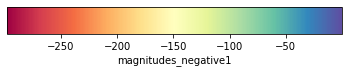

In [21]:
# select only negative magnitudes
means_neg, breaks_indexed, breaks_indexed_neg, binary_breaks, negative_binary_breaks = select_negatives(means_orig, breaks_orig)

save_plot(means_neg, output_dir, save_name = "magnitudes_negative" + timeseries_directory[-2])

# save negative means and breaks
export_GTiff(data_list, output_dir, array = means_neg ,output_name = "magnitudes_negative_" + timeseries_directory[-2] + ".tif")
export_GTiff(data_list, output_dir, array = binary_breaks ,output_name = "breaks_binary_" + timeseries_directory[-2] + ".tif")
export_GTiff(data_list, output_dir, array = negative_binary_breaks ,output_name = "breaks_binary_negative_" + timeseries_directory[-2] + ".tif")


In [22]:
dates_monitor = []
dates = data_list[0].cropped_dates

# collect dates for monitor period
for i in range(len(dates)):
    if start_monitor <= dates[i]:
        dates_monitor.append(dates[i])
dates_array = np.array(dates_monitor) # dates_array is the dates that are in the monitoring period


In [1]:
julian_breaks, year_breaks = get_julian_dates(dates_array,breaks_indexed)
negative_julian_breaks, negative_year_breaks = get_julian_dates(dates_array,breaks_indexed_neg)

# save negative means and breaks
export_GTiff(data_list, output_dir, array = julian_breaks ,output_name = "breaks_julian_" + timeseries_directory[-2] + ".tif")
export_GTiff(data_list, output_dir, array = negative_julian_breaks ,output_name = "breaks_julian_negative_" + timeseries_directory[-2] + ".tif")

export_GTiff(data_list, output_dir, array = year_breaks, output_name = "breaks_year_" +  timeseries_directory[-2] + ".tif")
export_GTiff(data_list, output_dir, array = negative_year_breaks, output_name = "breaks_year_negative_" +  timeseries_directory[-2] + ".tif")
    

NameError: name 'get_julian_dates' is not defined

# Classify output for plotting

In [24]:
breaks_years_neg, idx_starts, ticklist = classify_output(start_monitor,end_monitor,breaks_indexed_neg,dates_array)
#save_plot(breaks_years_neg, output_dir, save_name = "all_negative_breaks_years")

{2018: 0, 2019: 12, 2020: 35}


# Plot output

/home/dven/bfastmonitor_cpu/dven/plotting_funcs.py:164: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = axes.imshow(breaks_plot_years, cmap=cmap, vmin=0, vmax=bins, norm=norm)


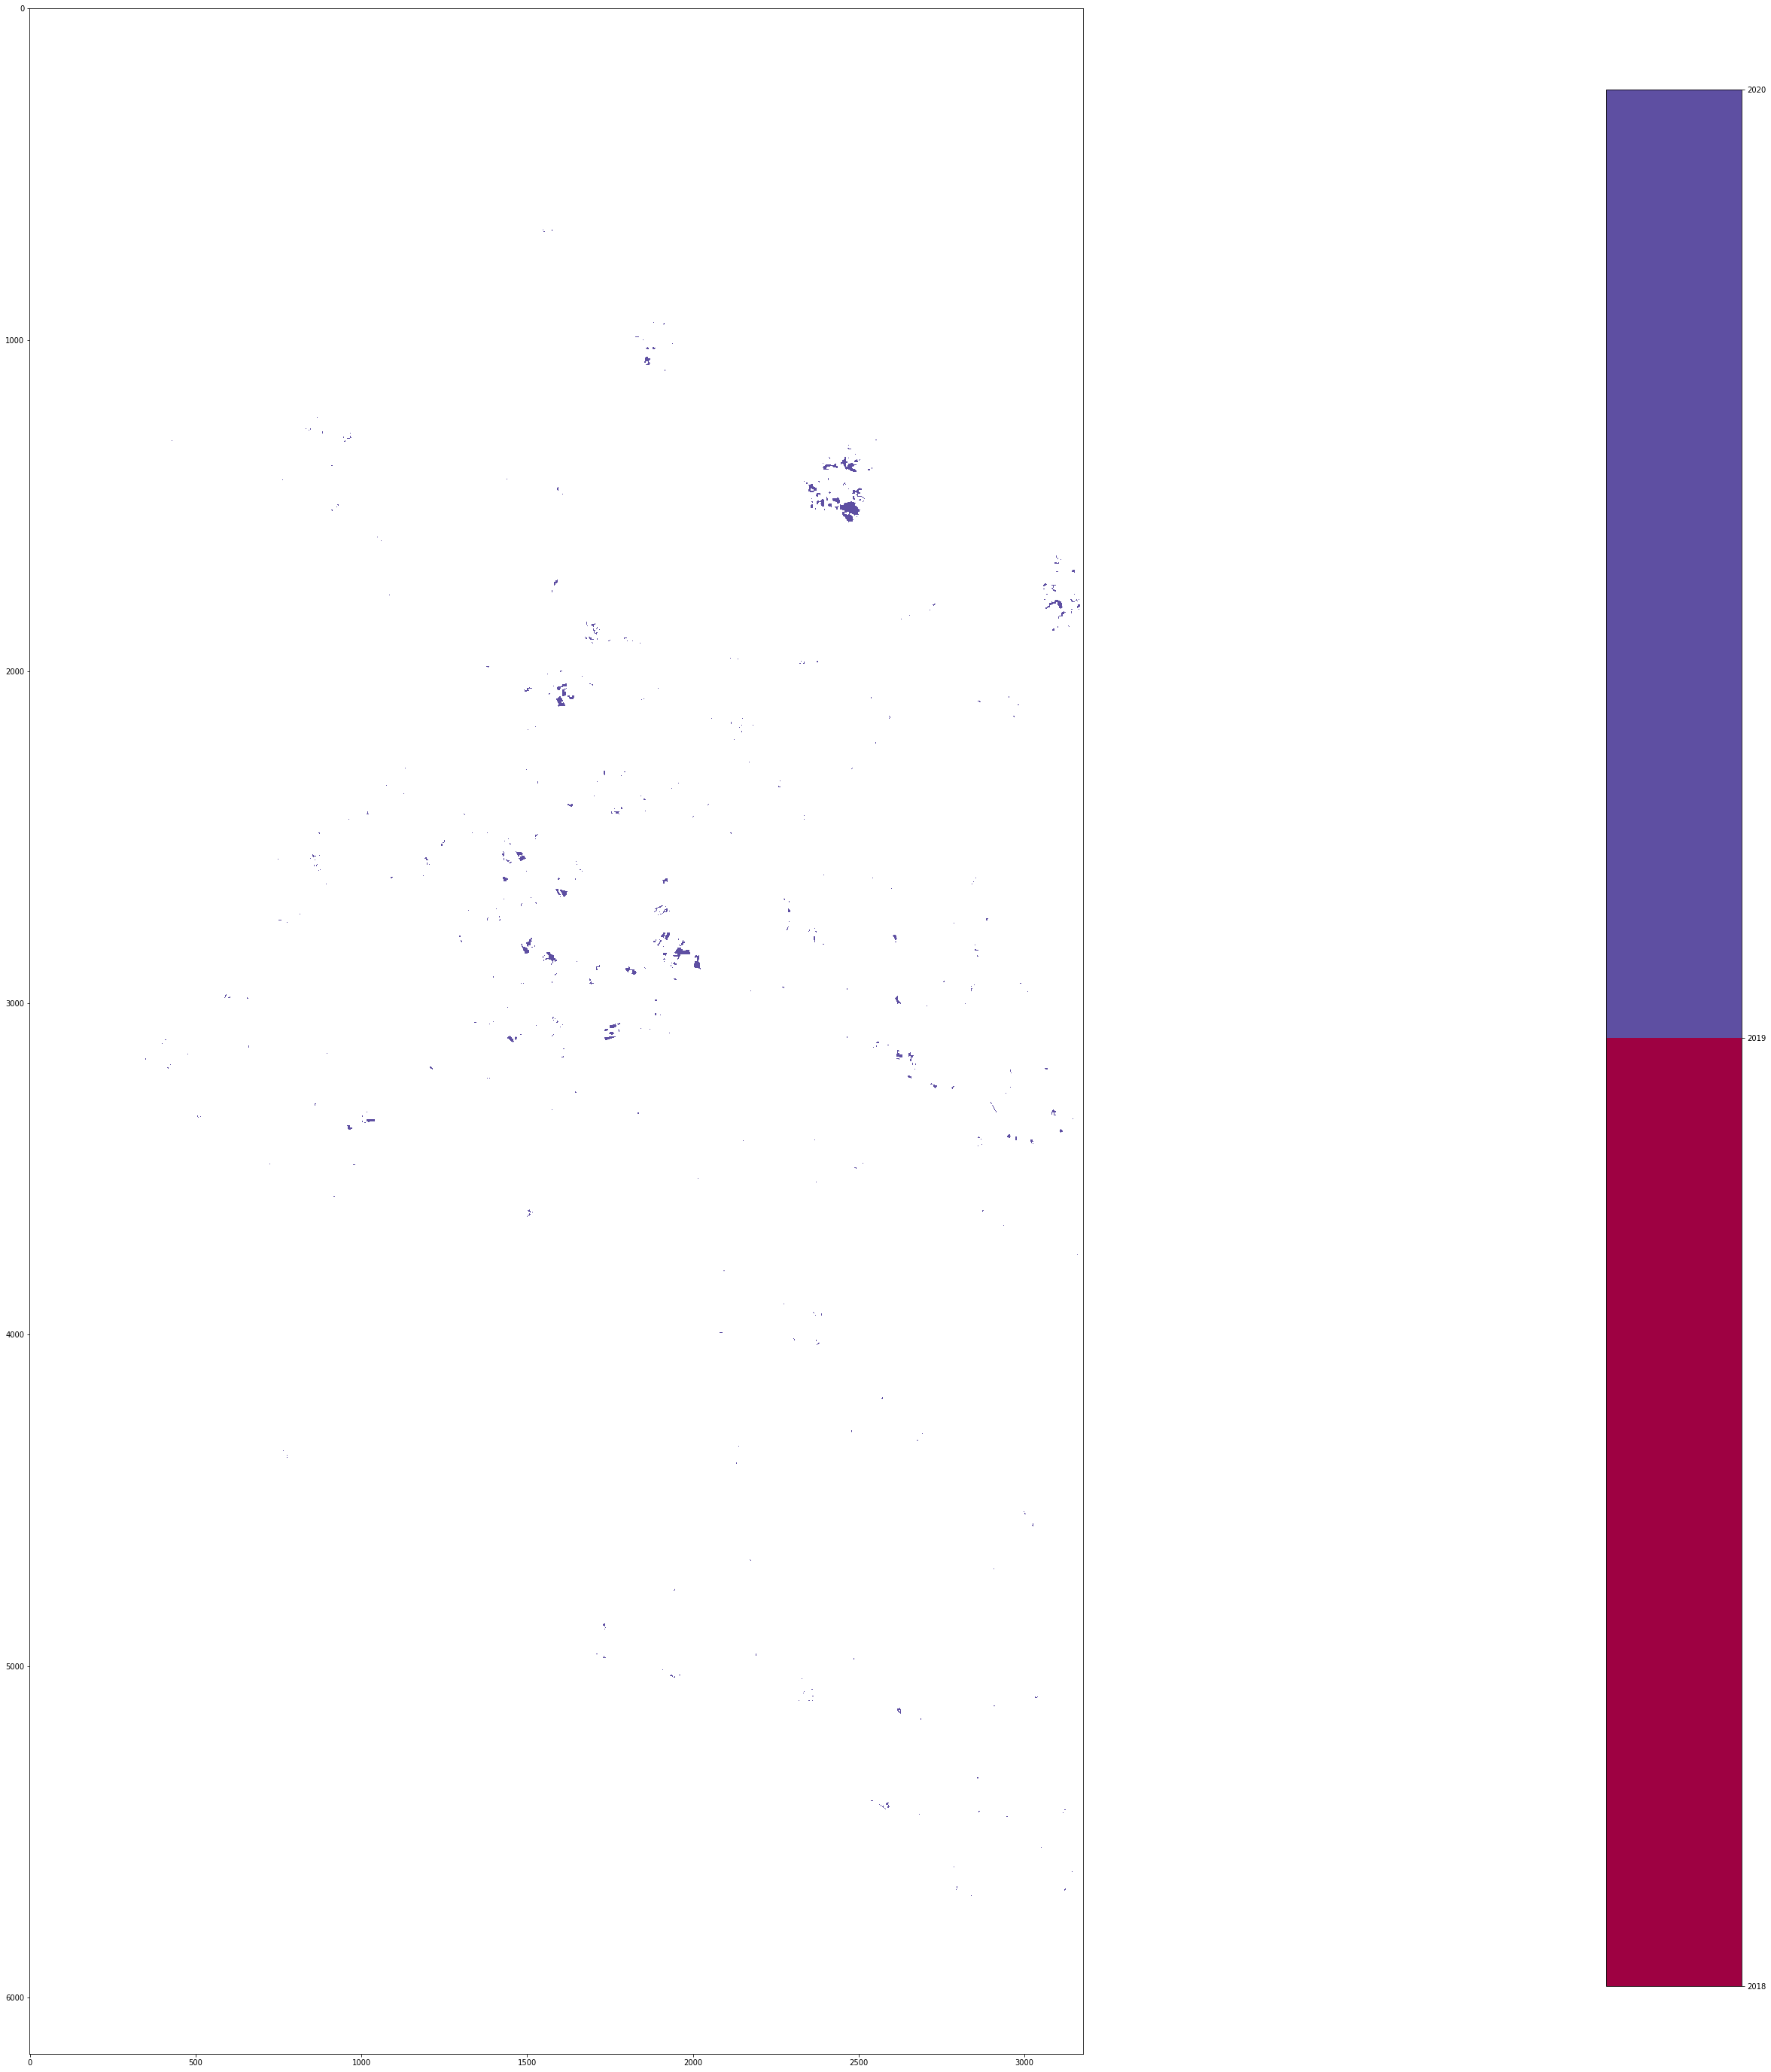

In [25]:
plot_output_matplotlib(idx_starts,breaks_years_neg,ticklist)
#asave_plot(breaks_years_neg, output_dir, save_name = "breaks_per_year")

In [23]:
#set_corners(output_dir,data_list)

min_lat  -37.50852586771174
max_lat  -37.50852586771174
min_lon  149.0822485957939
max_lon  149.0822485957939
saved in stored_time_series/output/output_0/corners.json


## Plot all of your segments and save as a html map. Small areas may not show on the map

In [31]:
display(plot_display_data_chooser)

interactive(children=(Dropdown(description='data to plot', layout=Layout(height='auto', width='500px'), option…

In [2]:
if not plot_display_data_chooser.result:
    print("make sure to run the block above")
m = merge_plots2(data_list = data_list, base_output_dir=base_output_dir,plot_name= plot_display_data_chooser.result)
m.save(base_output_dir + "/" +"0/" + plot_display_data_chooser.result + ".html")


NameError: name 'plot_display_data_chooser' is not defined